# LGBM PER CATEGORY

In [1]:
# %%
import pickle


with open("/path/to/pklFiles/cat_series_dict.pkl","rb") as file:
    
    cat_series_dict=pickle.load(file)


In [2]:
from darts.models import LightGBMModel
from darts.dataprocessing.transformers import  StaticCovariatesTransformer
import numpy as np
import sklearn
import pandas as pd
from darts.metrics import rmse,mae,rmsse
from darts import TimeSeries, concatenate
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
all_train_series_cat = {}
all_test_series_cat = {}
all_future_covs_cat = {}
all_ids = []
all_test_series_item = {}
#series_cat = {}


MIN_TRAIN_LENGTH = 150# for example


for store_id, cat_dict in cat_series_dict.items():
    all_train_series_cat[store_id] = {}
    all_test_series_cat[store_id] = {}
    all_future_covs_cat[store_id] = {}

    for cat_id, ts_list in cat_dict.items():
        train_series = []
        test_series = []
        future_covariates = []

        all_train_series = []
        all_test_series = []
        all_future_covariates = []
        for target, covs in ts_list:
            item_id = f"{store_id}_{target.static_covariates_values()[0][0]}"
            all_ids.append(item_id) # This Saves each unique Item_id with the same order as the series
            all_test_series_item[item_id] = target[-28:].astype(np.float32)   # This saves the test series for each item_id
            if len(target) < MIN_TRAIN_LENGTH:
                train_target = target[:-28].astype(np.float32)
                test_target = target[-28:].astype(np.float32)  
                all_train_series.append(train_target)
                all_test_series.append(test_target)
                all_future_covariates.append(covs.astype(np.float32))
                continue

            # if target.static_covariates is not None:
            #     # Ensure the column names exactly match your static covariate names.
            #     filtered_static_covs = target.static_covariates[["item_id", "dept_id"]]
            #     target = target.with_static_covariates(filtered_static_covs)
                
            train_target = target[:-28].astype(np.float32)
            test_target = target[-28:].astype(np.float32)  
            # series_target = target.astype(np.float32)

            # filtered_covs = covs[["sell_price", "tm_w_end", "tm_dw", "event_name_1_enc"]]

            train_series.append(train_target)
            test_series.append(test_target)
            future_covariates.append(covs.astype(np.float32))
            all_train_series.append(train_target)
            all_test_series.append(test_target)
            all_future_covariates.append(covs.astype(np.float32))

        all_train_series_cat[store_id][cat_id] = all_train_series
        all_test_series_cat[store_id][cat_id] = all_test_series
        all_future_covs_cat[store_id][cat_id] = all_future_covariates
        #series_cat[store_id][cat_id] = series

        static_scaler = StaticCovariatesTransformer(transformer_num=None, cols_num=None) #cols_cat=["item_id", "dept_id", "cat_id"])
        static_scaler.fit(all_train_series_cat[store_id][cat_id])
        all_train_series_cat[store_id][cat_id] = static_scaler.transform(all_train_series_cat[store_id][cat_id])
        all_test_series_cat[store_id][cat_id] = static_scaler.transform(all_test_series_cat[store_id][cat_id])
        #series_cat[store_id][cat_id] = static_scaler.transform(series_cat[store_id][cat_id])


predicting

In [ ]:
forecast_dict = {}
for store_id, cat_dict in cat_series_dict.items():
    forecast_dict[store_id] = {}
    for cat_id in cat_dict.keys():
        model =  LightGBMModel.load(f"/path/to/BasicModels/lgbm/Category_Forecasting/Cat_outchunk/Cat_outchunk{store_id}_{cat_id}")
        forecast_dict[store_id][cat_id] = model.predict(
                                                    n=28,
                                                    series=all_train_series_cat[store_id][cat_id],
                                                    future_covariates= all_future_covs_cat[store_id][cat_id]
                                        )

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lam

7:44 hours training

In [ ]:
rmse_dict = {}
mae_dict = {}

for store_id, cat_dict in cat_series_dict.items():
    rmse_dict[store_id] = {}
    mae_dict[store_id] = {}
    for cat_id in cat_dict.keys():
        rmse_dict[store_id][cat_id] = rmse(all_test_series_cat[store_id][cat_id],forecast_dict[store_id][cat_id])
        mae_dict[store_id][cat_id] = mae(all_test_series_cat[store_id][cat_id],forecast_dict[store_id][cat_id])

In [ ]:
import numpy as np

# Print metrics for every category within each store,
# compute per-store averages, and then compute the global average.

# Loop through each store
for store_id in rmse_dict:
    print(f"Store: {store_id}")
    
    # Lists to accumulate per-category averaged errors for this store.
    store_cat_rmse = []
    store_cat_mae  = []
    
    # Loop through each category in the store
    for cat_id in rmse_dict[store_id]:
        # Compute the mean error for the category from the list of errors.
        cat_rmse_list = rmse_dict[store_id][cat_id]
        cat_mae_list  = mae_dict[store_id][cat_id]
        
        cat_rmse = np.mean(cat_rmse_list)
        cat_mae  = np.mean(cat_mae_list)
        
        # Print the category-level averages
        print(f"    Category {cat_id}: RMSE = {cat_rmse:.2f}, MAE = {cat_mae:.2f}")
        
        # Save the averages to compute the store's average later.
        store_cat_rmse.append(cat_rmse)
        store_cat_mae.append(cat_mae)
    
    # Compute and print the store's average (averaging the per-category averages)
    store_avg_rmse = np.mean(store_cat_rmse)
    store_avg_mae  = np.mean(store_cat_mae)
    print(f"--> Store {store_id} Average: RMSE = {store_avg_rmse:.2f}, MAE = {store_avg_mae:.2f}\n")



Store: CA_1
    Category FOODS: RMSE = 2.04, MAE = 1.63
    Category HOBBIES: RMSE = 1.26, MAE = 0.93
    Category HOUSEHOLD: RMSE = 1.03, MAE = 0.81
--> Store CA_1 Average: RMSE = 1.44, MAE = 1.12

Store: CA_2
    Category FOODS: RMSE = 2.10, MAE = 1.63
    Category HOBBIES: RMSE = 1.12, MAE = 0.81
    Category HOUSEHOLD: RMSE = 1.26, MAE = 0.98
--> Store CA_2 Average: RMSE = 1.50, MAE = 1.14

Store: CA_3
    Category FOODS: RMSE = 2.50, MAE = 1.98
    Category HOBBIES: RMSE = 1.30, MAE = 1.00
    Category HOUSEHOLD: RMSE = 1.62, MAE = 1.29
--> Store CA_3 Average: RMSE = 1.81, MAE = 1.42

Store: CA_4
    Category FOODS: RMSE = 1.44, MAE = 1.13
    Category HOBBIES: RMSE = 0.98, MAE = 0.70
    Category HOUSEHOLD: RMSE = 0.78, MAE = 0.60
--> Store CA_4 Average: RMSE = 1.06, MAE = 0.81

Store: TX_1
    Category FOODS: RMSE = 1.50, MAE = 1.15
    Category HOBBIES: RMSE = 0.86, MAE = 0.62
    Category HOUSEHOLD: RMSE = 0.96, MAE = 0.74
--> Store TX_1 Average: RMSE = 1.11, MAE = 0.84

Store

In [ ]:
# For the global average, aggregate all error values from all categories in all stores.
all_rmse = []
all_mae  = []
for store_id in rmse_dict:
    for cat_id in rmse_dict[store_id]:
        all_rmse.extend(rmse_dict[store_id][cat_id])
        all_mae.extend(mae_dict[store_id][cat_id])

global_avg_rmse = np.mean(all_rmse)
global_avg_mae  = np.mean(all_mae)
print(f"Global Average: RMSE = {global_avg_rmse:.2f}, MAE = {global_avg_mae:.2f}")

Global Average: RMSE = 1.46, MAE = 1.14


# Weighted EVAL

In [ ]:
weights_df = pd.read_csv("/path/to/ExtraFiles/weights_validation.csv")
weights_df = weights_df[weights_df["Level_id"] == "Level12"].copy()
weights_dict = {}

for _, row in weights_df.iterrows():
    # Extract store_id from Agg_Level_2
    store_id = row["Agg_Level_2"]
    # Extract cat_id by taking the first part of Agg_Level_1 (splitting by '_')
    cat_id = row["Agg_Level_1"].split('_')[0]
    # Get the weight value
    weight = row["weight"]
    
    # Ensure the store_id key exists
    if store_id not in weights_dict:
        weights_dict[store_id] = {}
    # Ensure the cat_id key exists within the store_id
    if cat_id not in weights_dict[store_id]:
        weights_dict[store_id][cat_id] = []
    
    # Append the weight to the list
    weights_dict[store_id][cat_id].append(weight)

In [ ]:
all_wrmsse = []
for store_id, cat_dict in cat_series_dict.items():
    for cat_id, cat_series in cat_dict.items():
        forecast_values = forecast_dict[store_id][cat_id]
        weight_values =  weights_dict[store_id][cat_id]
        for (ts, _), forecast_value, weight_value in zip(cat_series, forecast_values, weight_values):
            test_target = ts[-28:].astype(np.float32)

            wrmsse_value = weight_value*rmsse(actual_series=test_target,
                                                pred_series=forecast_value,
                                                insample=ts[:-28].astype(np.float32))
            all_wrmsse.append(wrmsse_value)
        

In [ ]:
total_wrmse = sum(all_wrmsse)
print(f"The total WRMSE is -> {total_wrmse}")

The total WRMSE is -> 0.8979902201061384


# Normal RMSE and MAE

In [ ]:
store_ids = list(rmse_dict.keys())
cat_ids = list(rmse_dict[store_ids[0]].values())

In [ ]:
rmse_item_dict = {}
mae_item_dict  = {}
index = 0
for store_id in rmse_dict:
    for cat_id in rmse_dict[store_id]:
        for item in zip(rmse_dict[store_id][cat_id], mae_dict[store_id][cat_id]):
            rmse_item_dict[all_ids[index]] = item[0]
            mae_item_dict[all_ids[index]] = item[1]
            index += 1


In [ ]:
forecast_item_dict = {}
index = 0
for store_id in rmse_dict:
    for cat_id in rmse_dict[store_id]:
        for forecast in forecast_dict[store_id][cat_id]:
            forecast_item_dict[all_ids[index]] = forecast
            index += 1  

In [ ]:
max_rmse_key = max(rmse_item_dict, key=rmse_item_dict.get)
max_mae_key = max(mae_item_dict, key=mae_item_dict.get)

print(f"Highest RMSE: {rmse_item_dict[max_rmse_key]} at {max_rmse_key}")
print(f"Highest MAE: {mae_item_dict[max_mae_key]} at {max_mae_key}")

Highest RMSE: 59.90870627306236 at CA_3_FOODS_3_681
Highest MAE: 54.83829404302709 at CA_3_FOODS_3_681


<Axes: xlabel='date'>

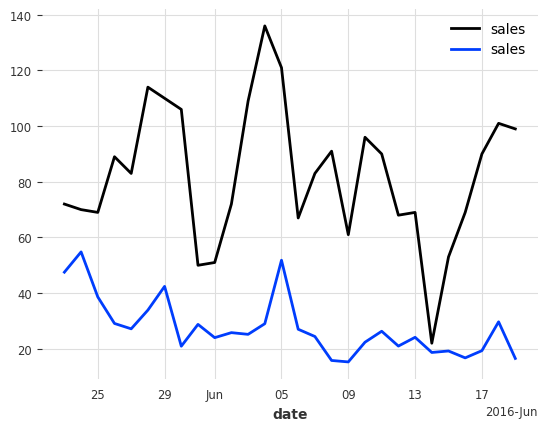

In [ ]:
all_test_series_item['CA_3_FOODS_3_681'].plot()
forecast_item_dict['CA_3_FOODS_3_681'].plot()

# DIKA MOU

In [ ]:
metrics_df = pd.DataFrame({
    'id': all_ids,
    'RMSE': list(rmse_item_dict.values()),
    'MAE' : list(mae_item_dict.values())
})


In [ ]:
print(f"Number of RMSE's above 10 -> {(metrics_df['RMSE'] > 10).sum()}")
# Determine the number of top 10% elements
top_10_percent_count = int(len(metrics_df) * 0.10)

# Sort RMSE values in descending order and take the top 10%
top_10_percent_rmse_sum = metrics_df['RMSE'].nlargest(top_10_percent_count).sum()

print(top_10_percent_rmse_sum)


Number of RMSE's above 10 -> 282
17195.485808893965


In [21]:
# Calculate additional statistics
mean_rmse = metrics_df['RMSE'].mean()
median_rmse = metrics_df['RMSE'].median()
std_rmse = metrics_df['RMSE'].std()
min_rmse = metrics_df['RMSE'].min()
max_rmse = metrics_df['RMSE'].max()

# Print the statistics
print("\nRMSE Statistics:")
print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Median RMSE: {median_rmse:.2f}")
print(f"Standard Deviation of RMSE: {std_rmse:.2f}")
print(f"Minimum RMSE: {min_rmse:.2f}")
print(f"Maximum RMSE: {max_rmse:.2f}")


RMSE Statistics:
Mean RMSE: 1.46
Median RMSE: 0.94
Standard Deviation of RMSE: 2.02
Minimum RMSE: 0.18
Maximum RMSE: 59.91


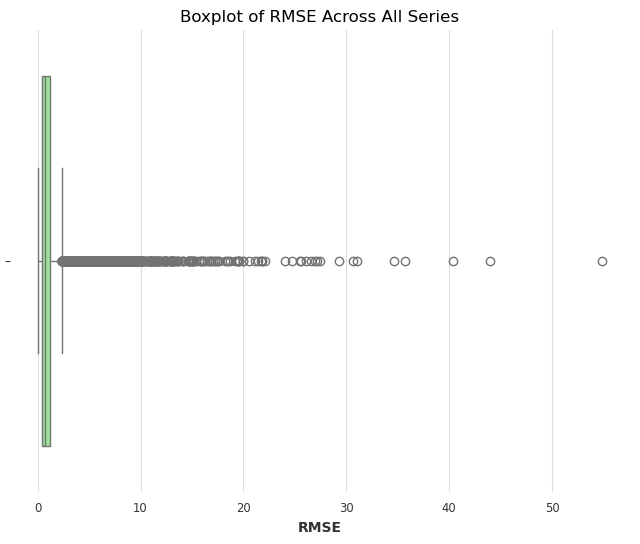

In [29]:
# Plot a boxplot of RMSE values
plt.figure(figsize=(8, 6))
sns.boxplot(x=metrics_df['MAE'], color='lightgreen')
plt.title('Boxplot of RMSE Across All Series')
plt.xlabel('RMSE')
plt.show()


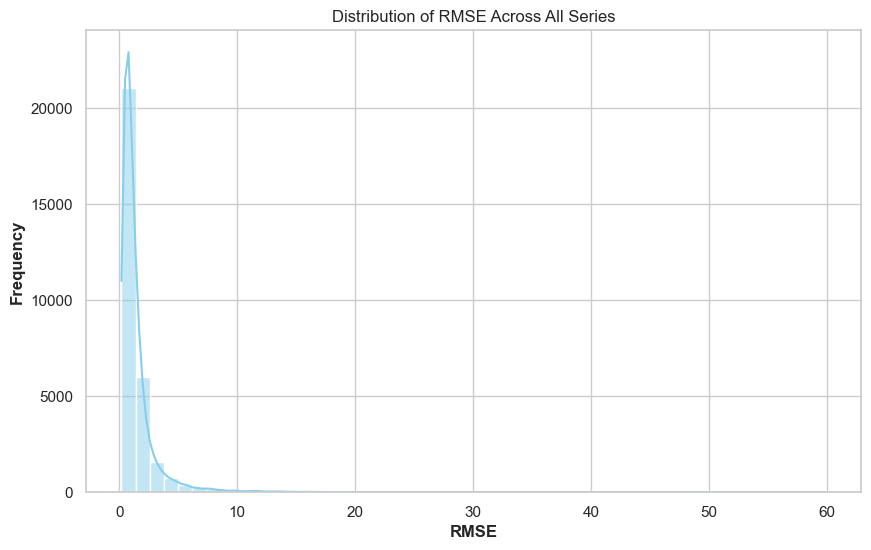

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot a histogram of RMSE values
plt.figure(figsize=(10, 6))
sns.histplot(metrics_df['RMSE'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of RMSE Across All Series')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.show()


# Explainability

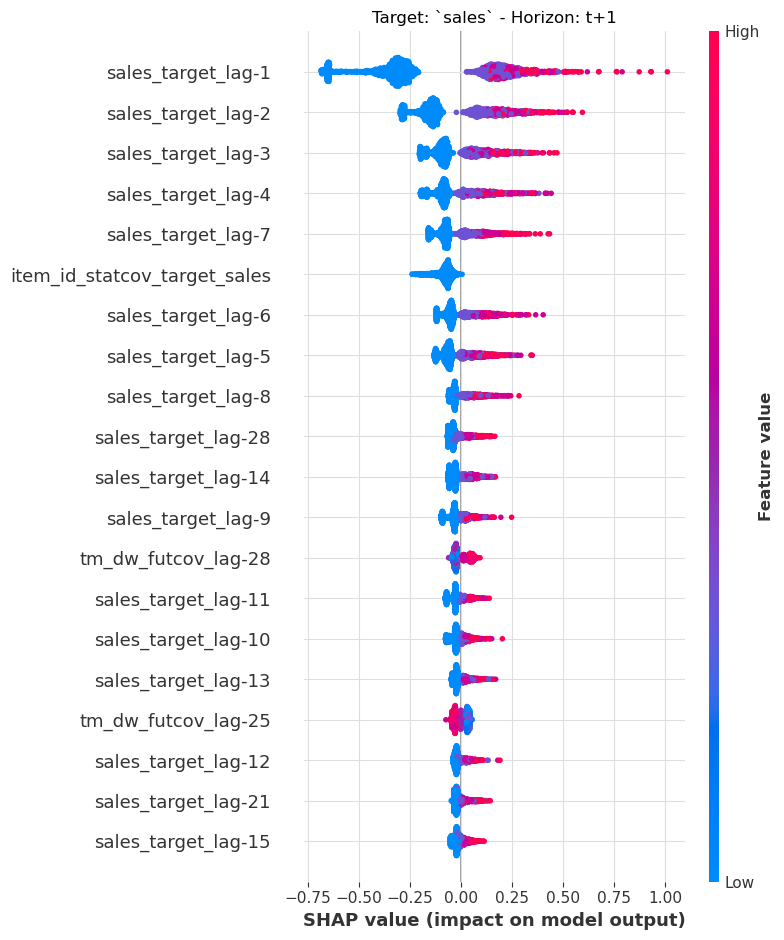

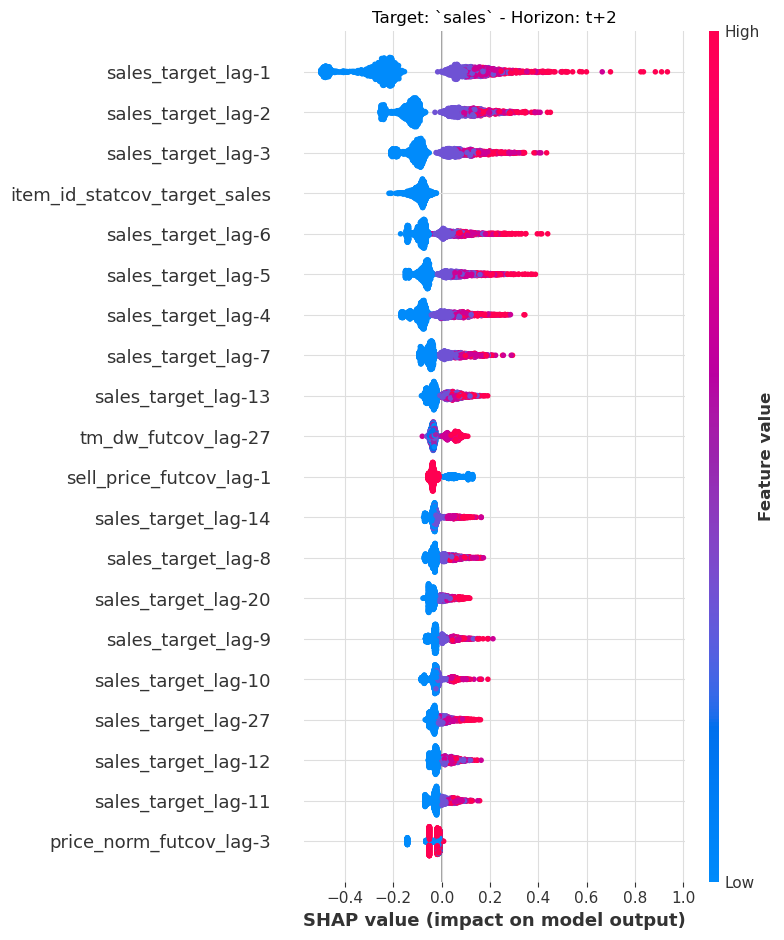

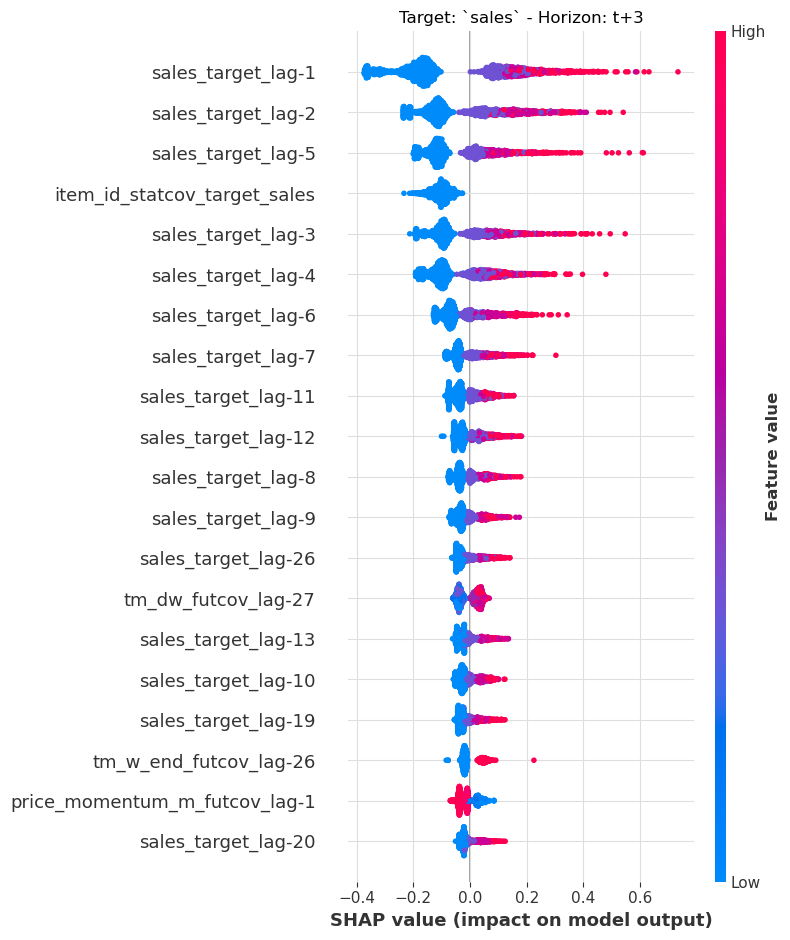

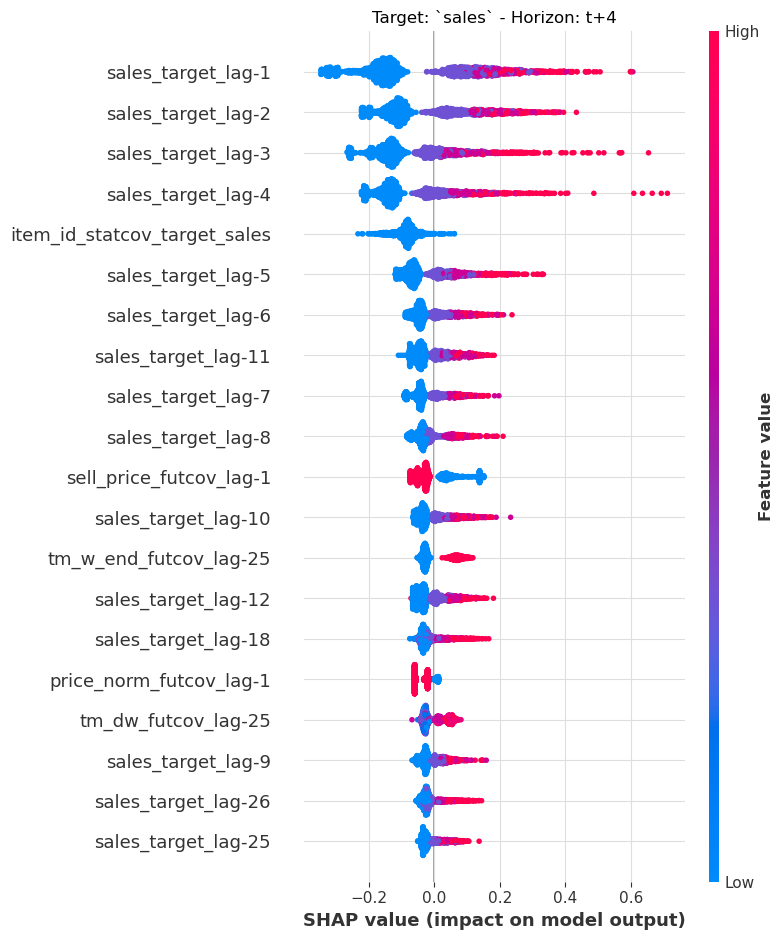

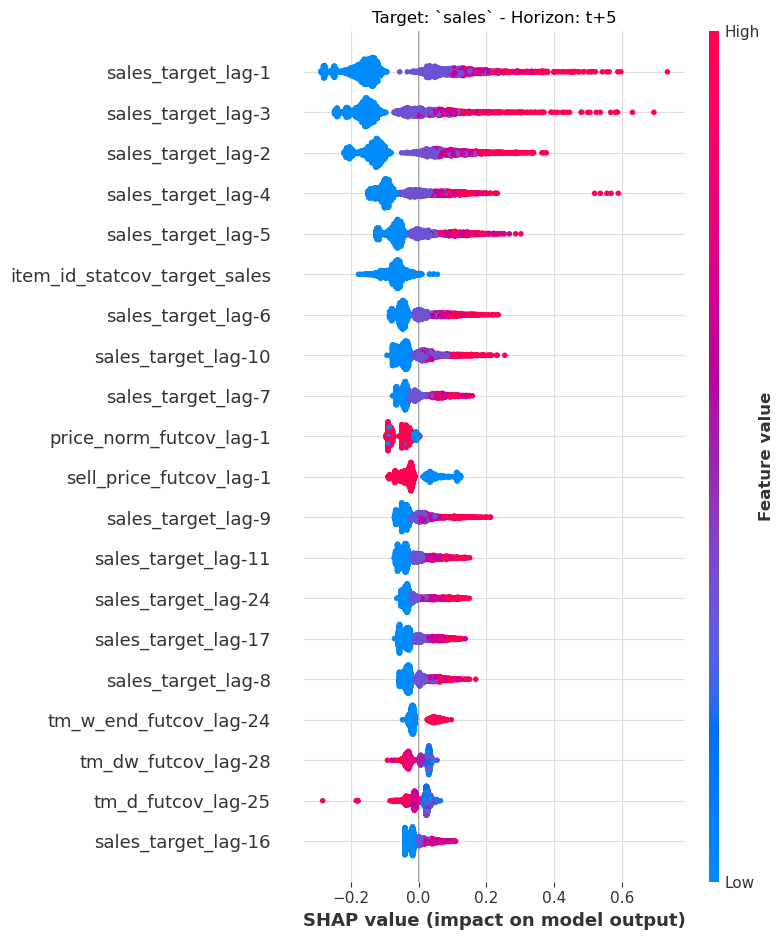

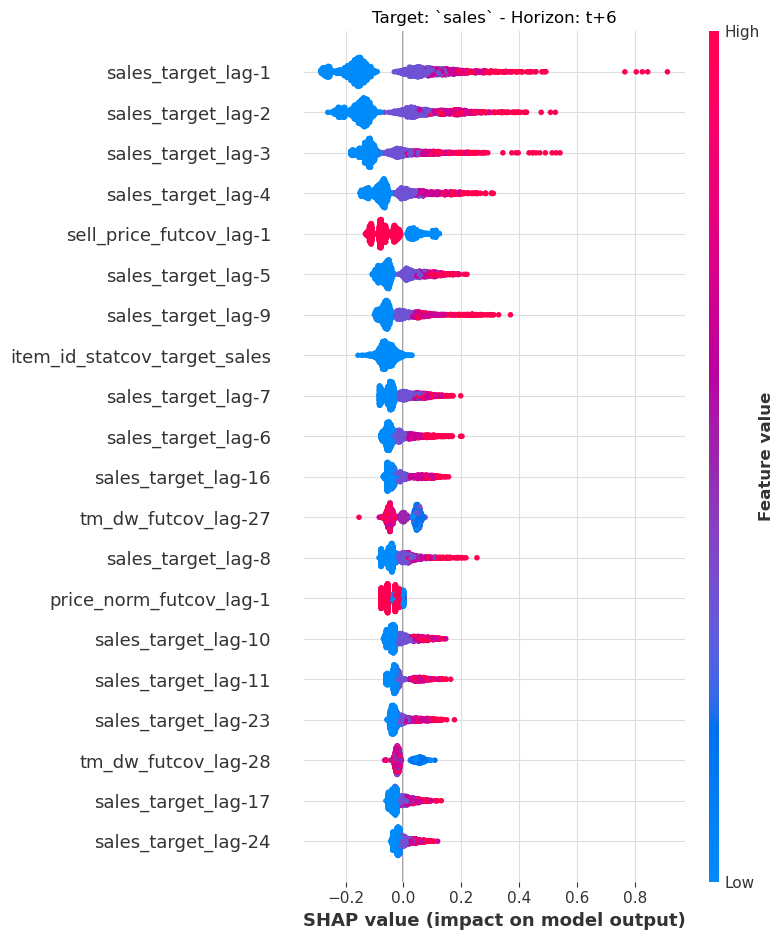

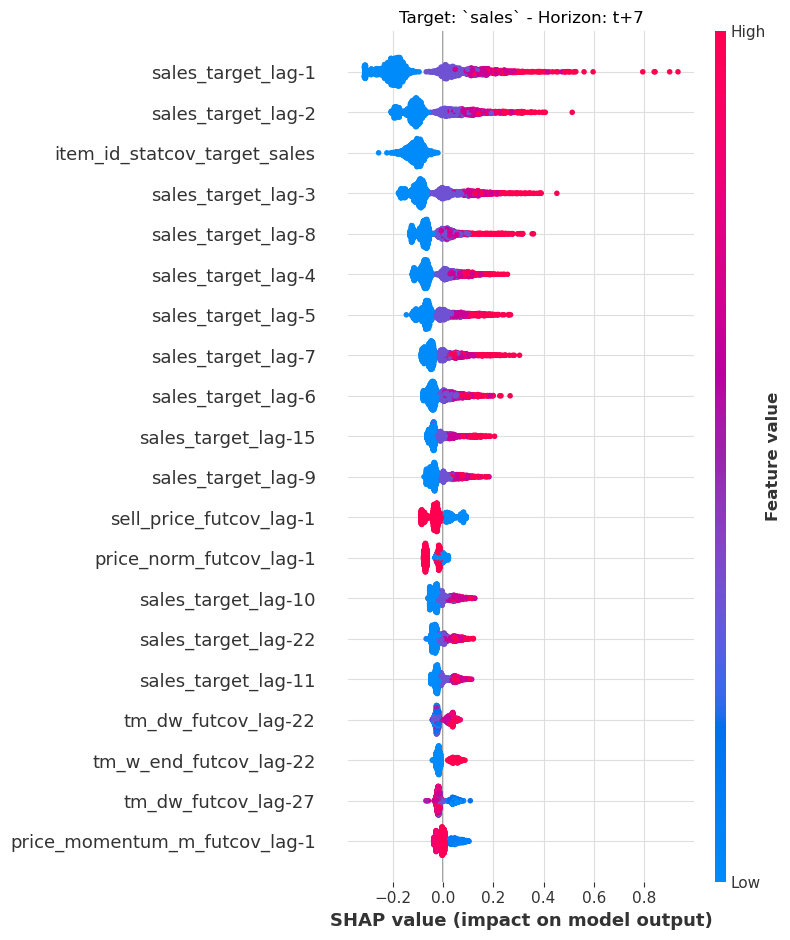

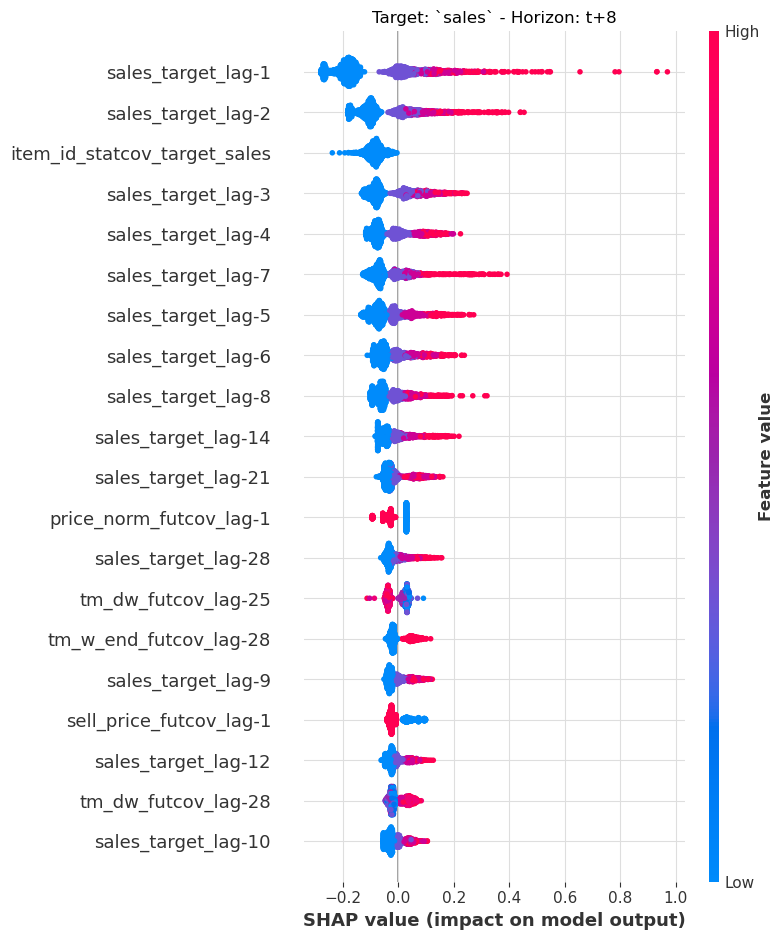

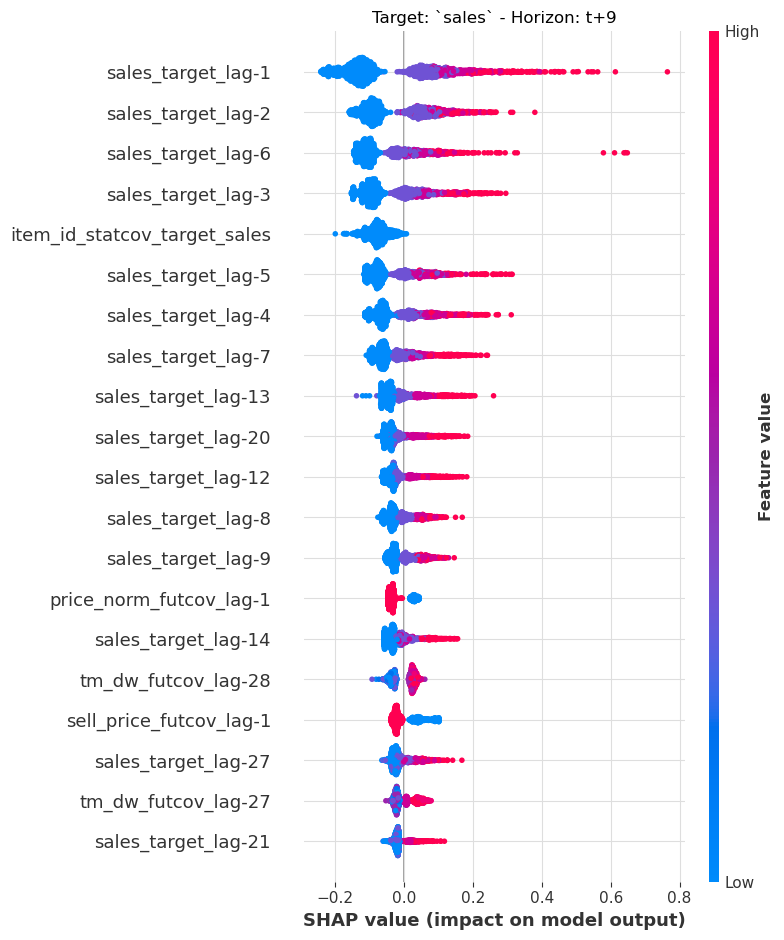

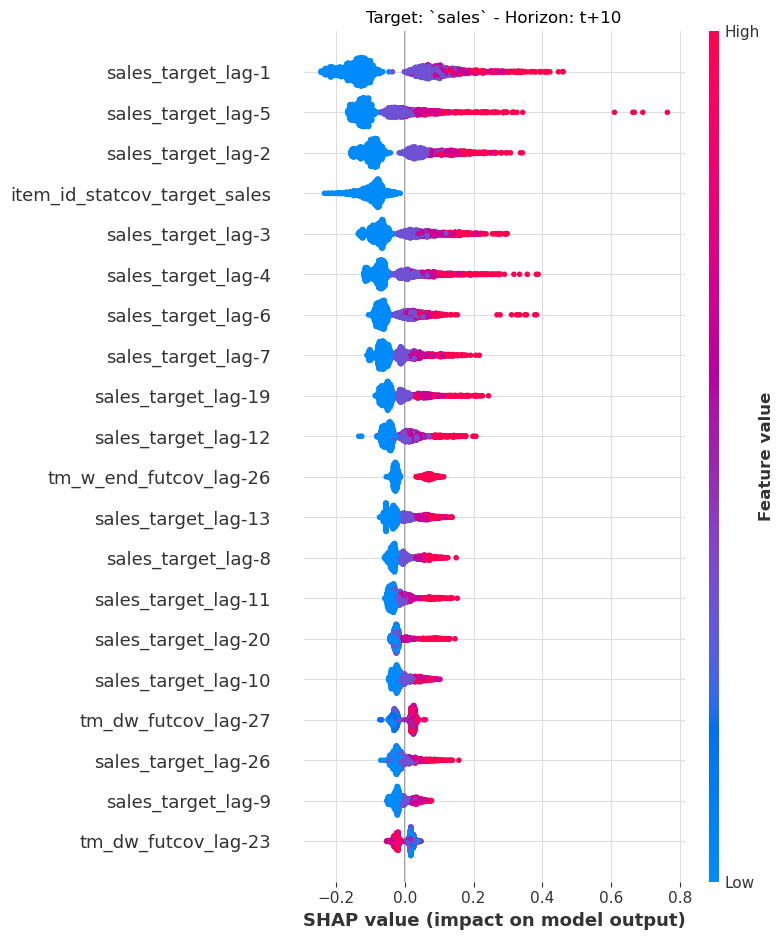

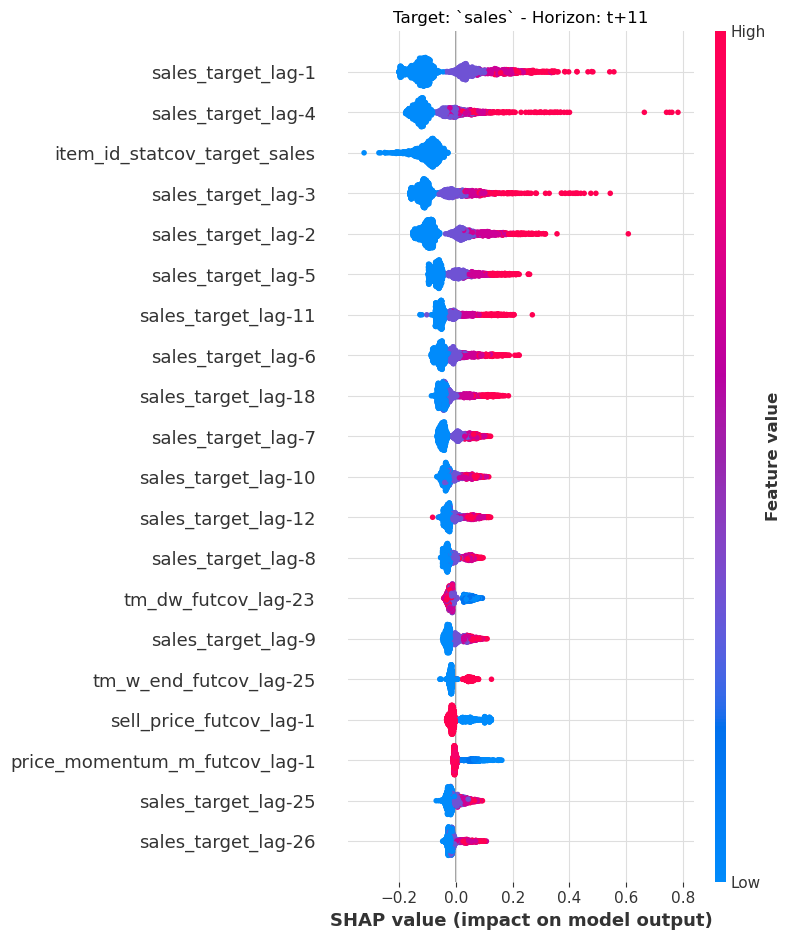

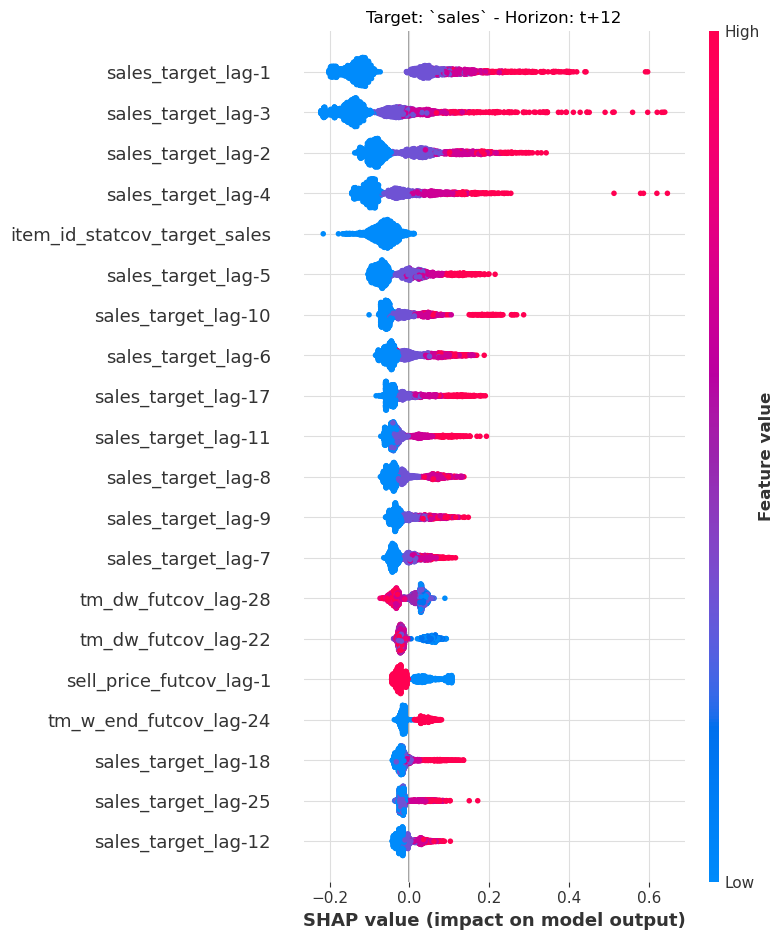

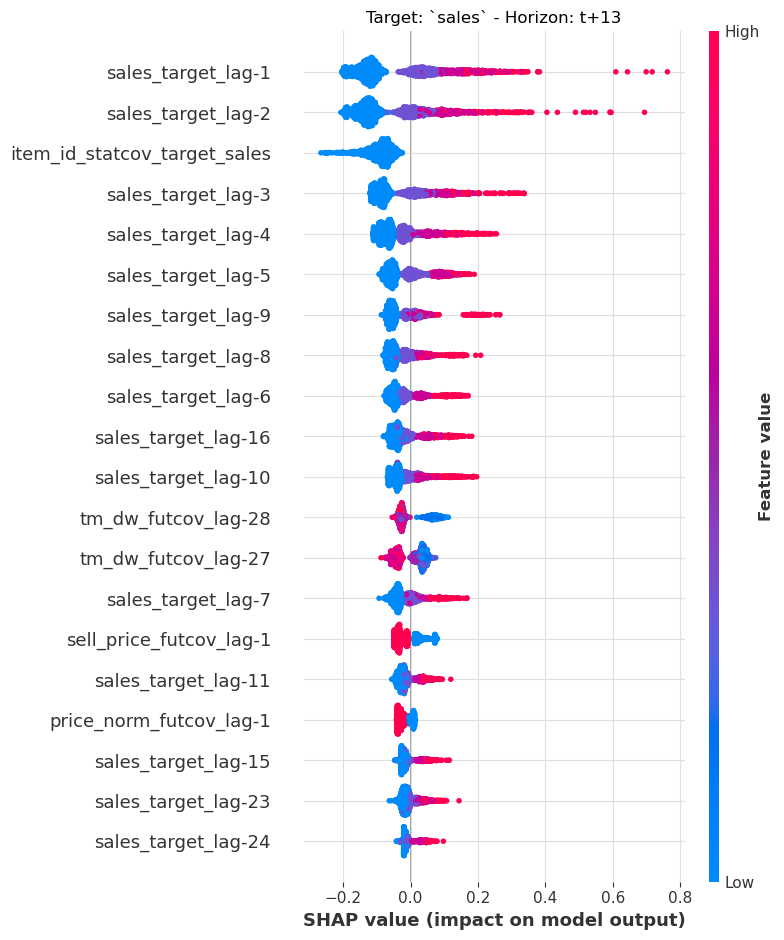

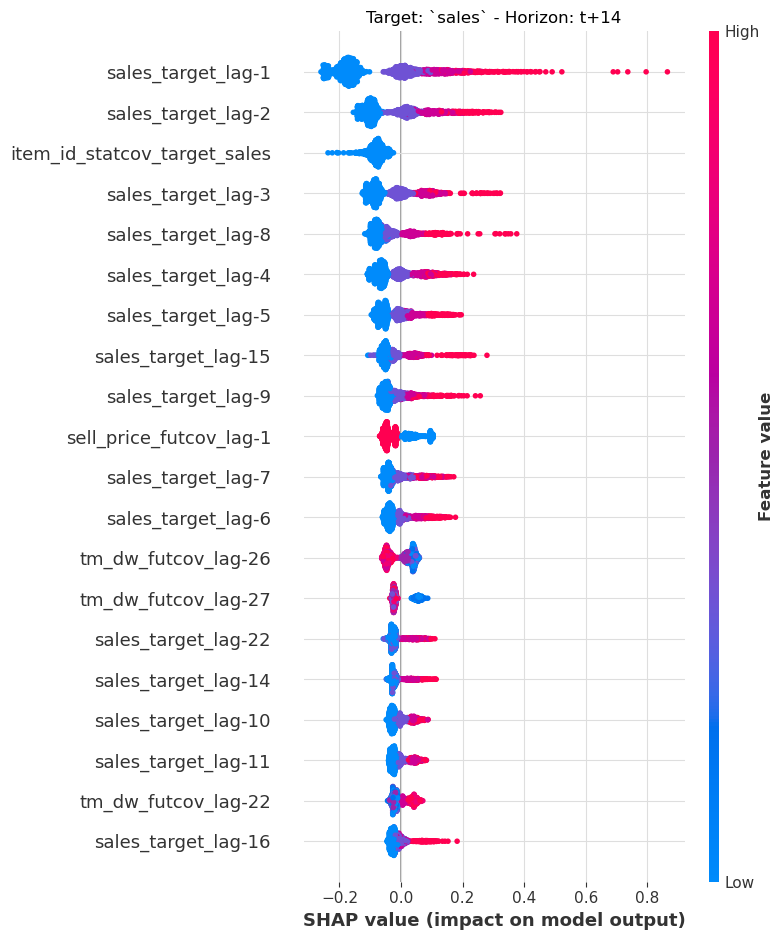

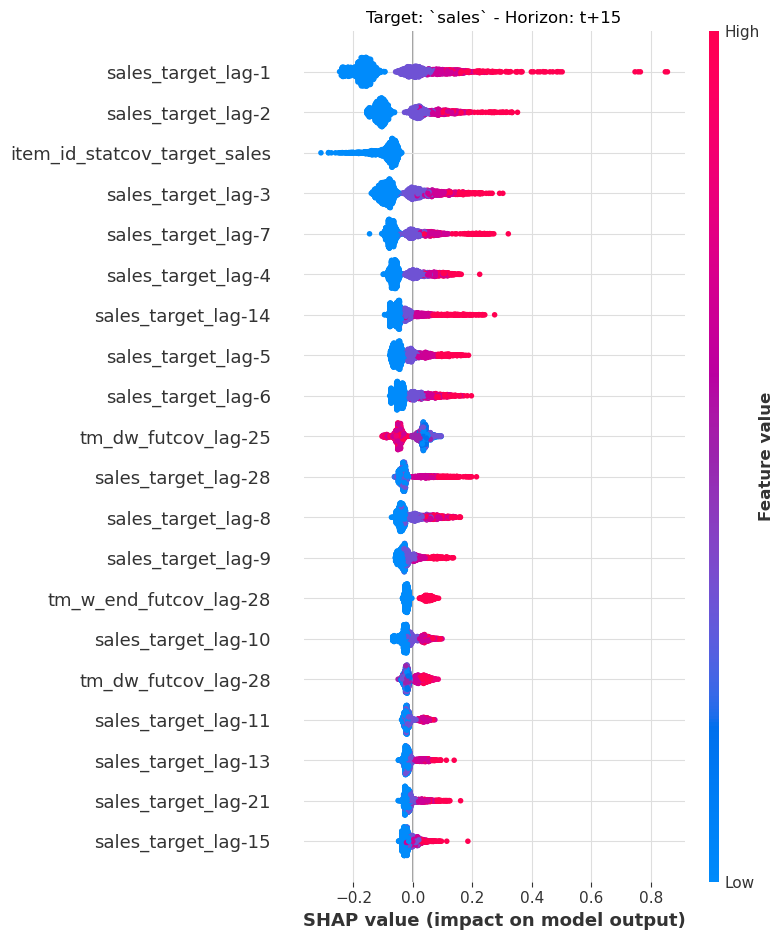

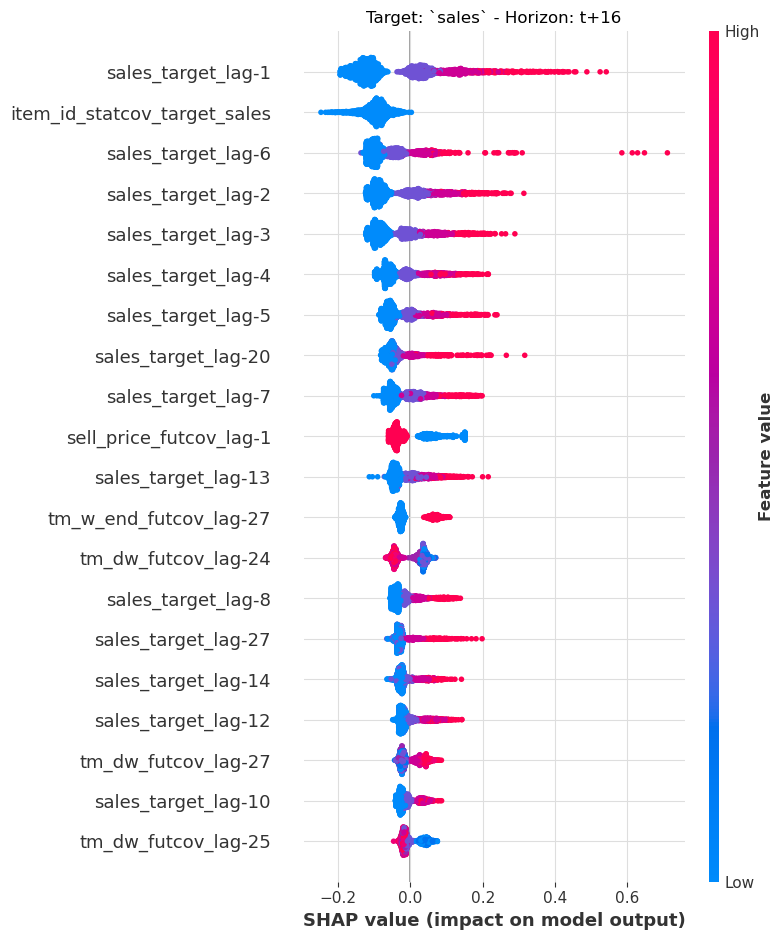

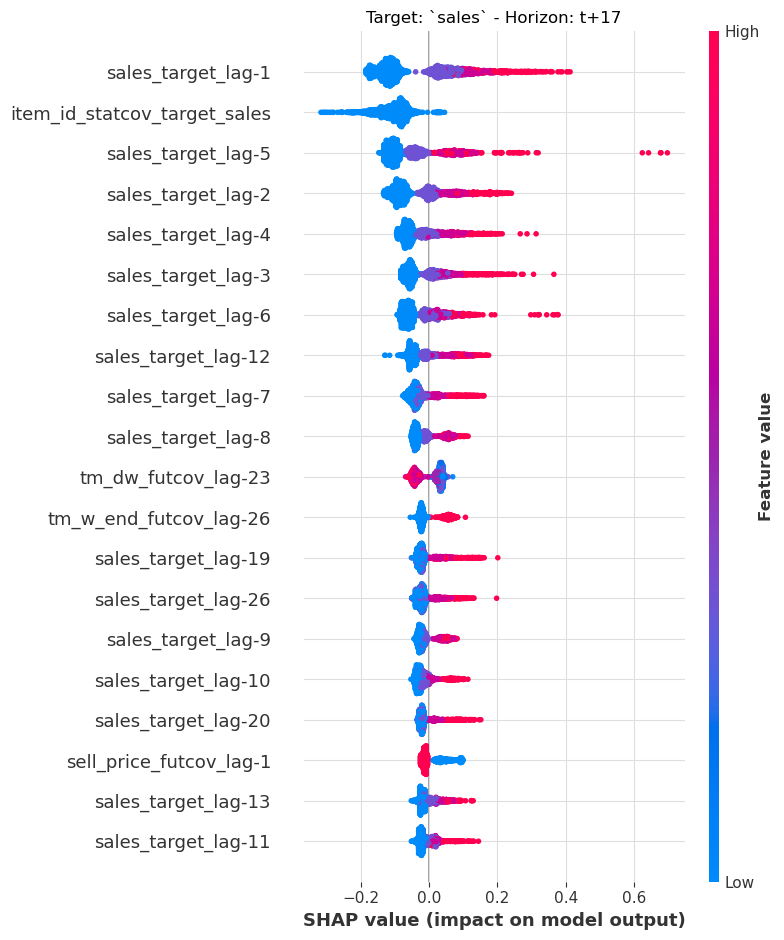

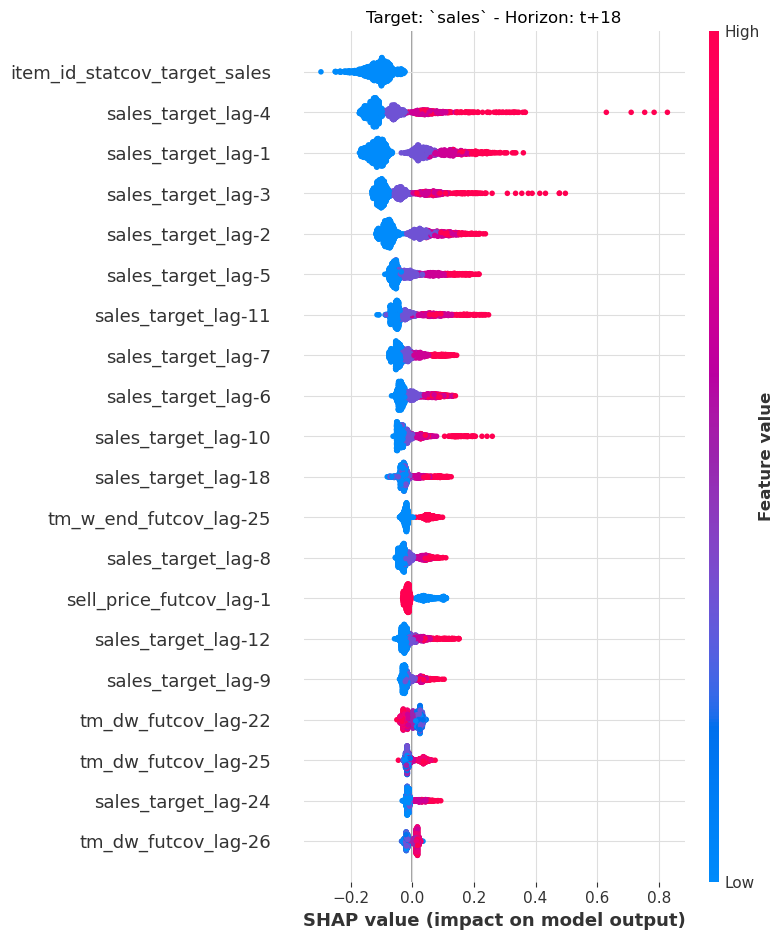

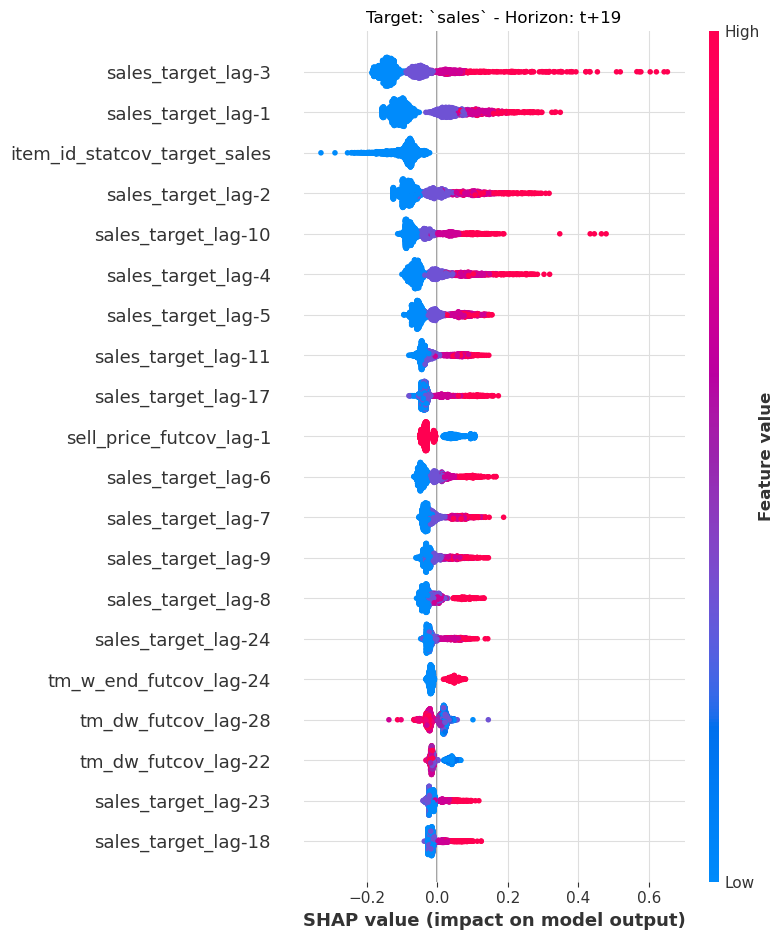

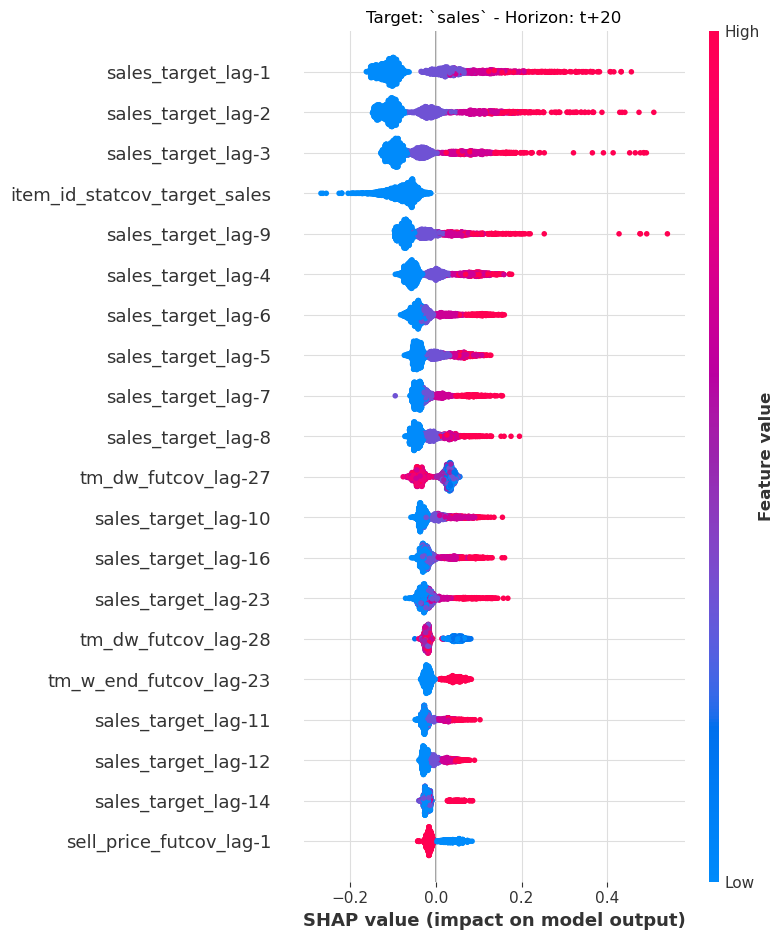

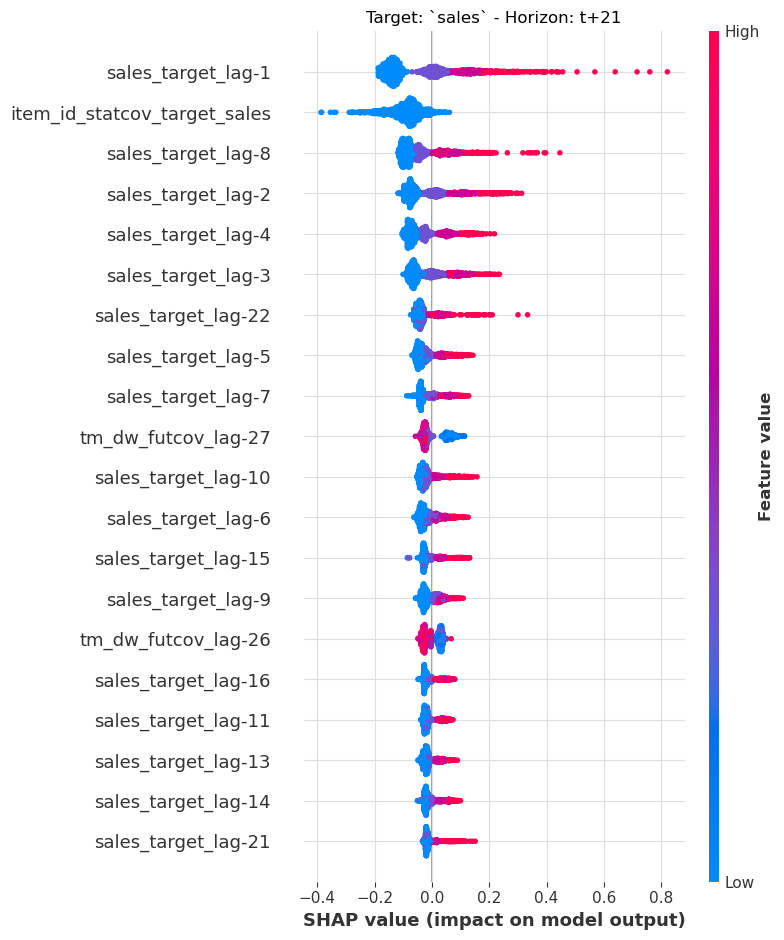

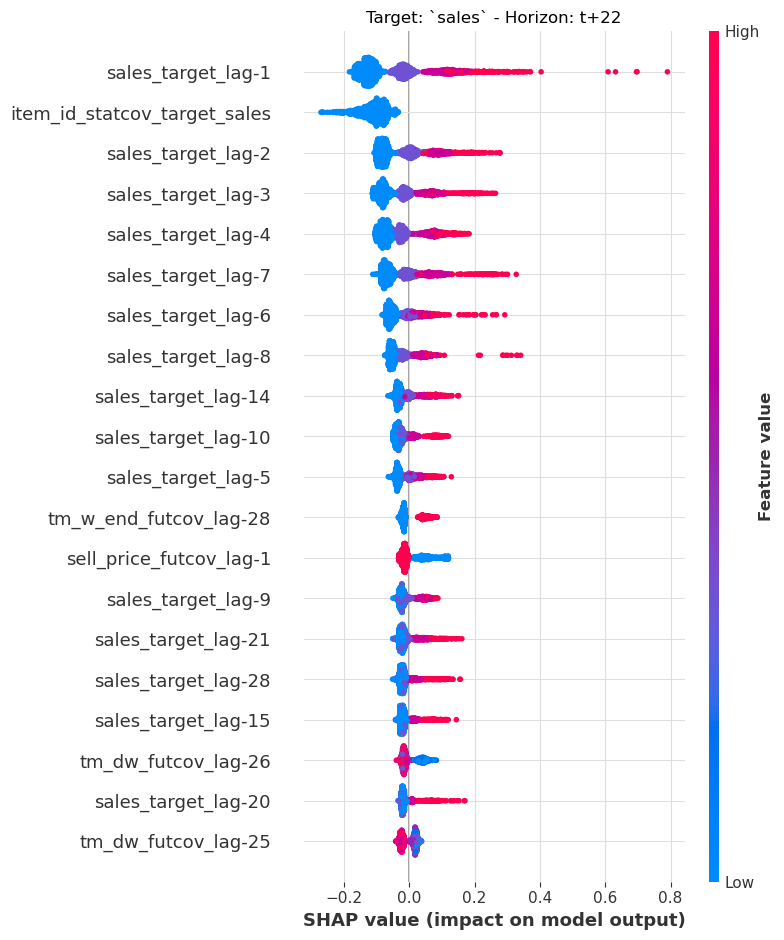

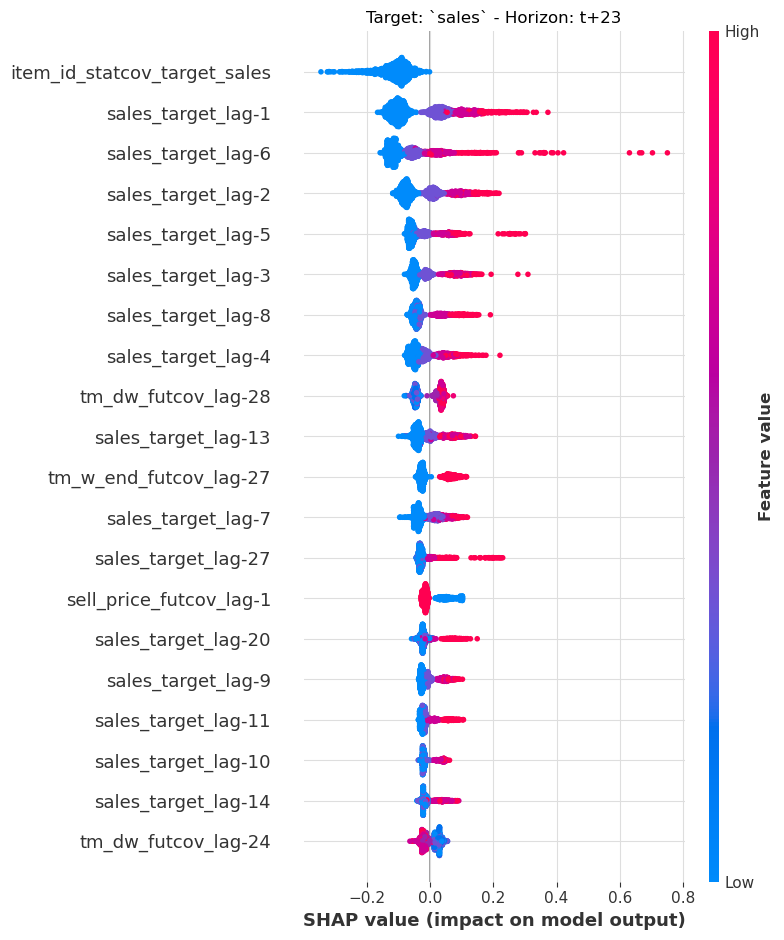

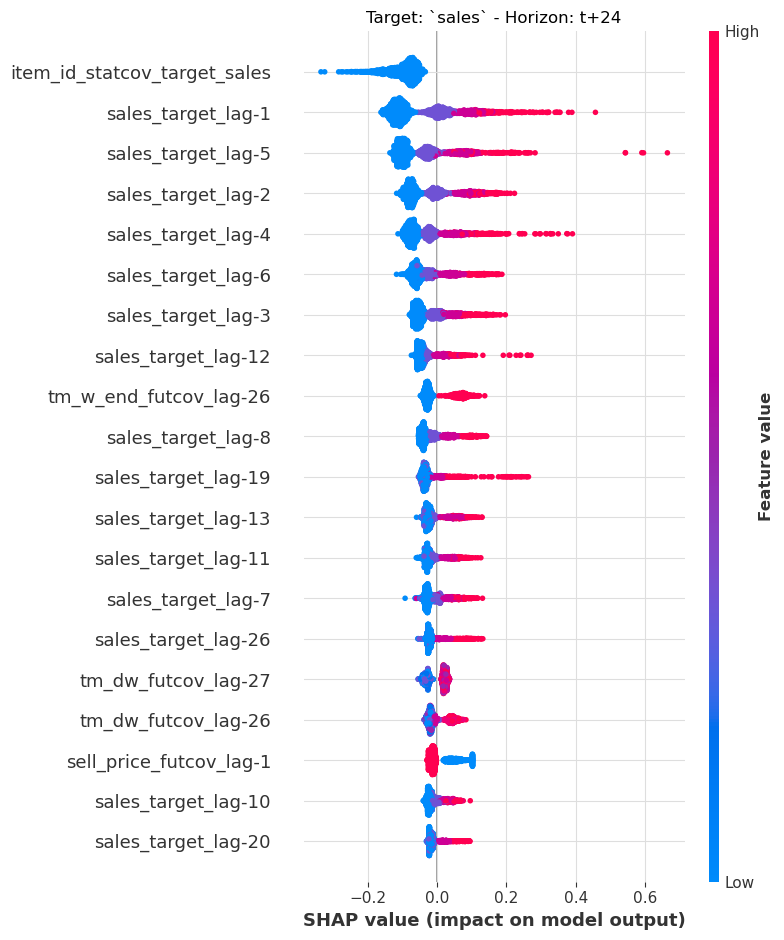

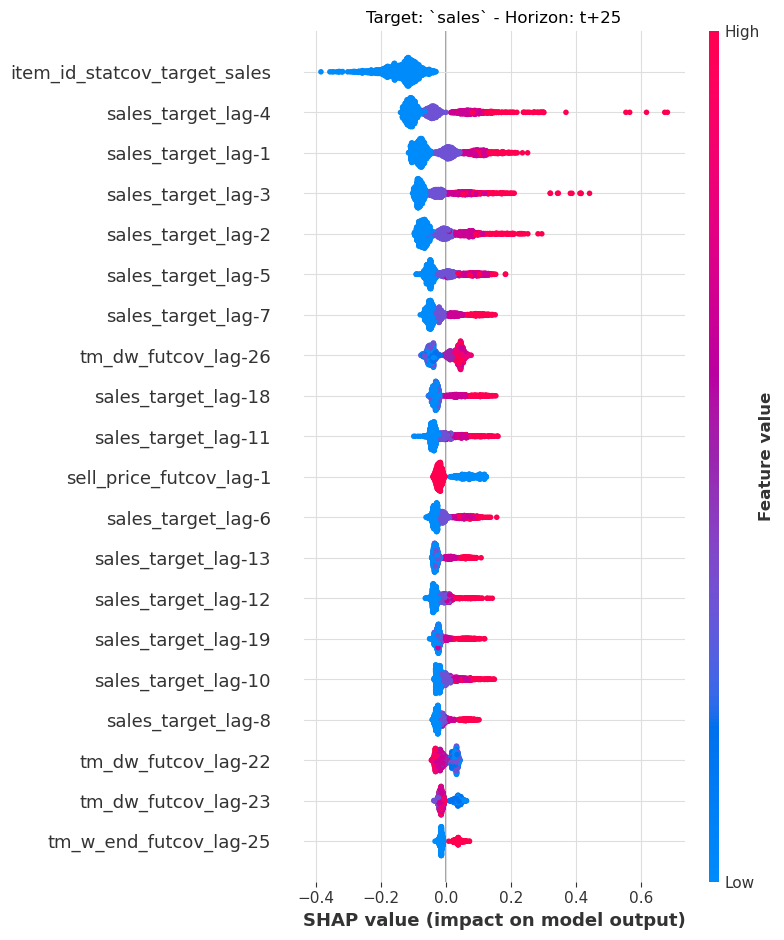

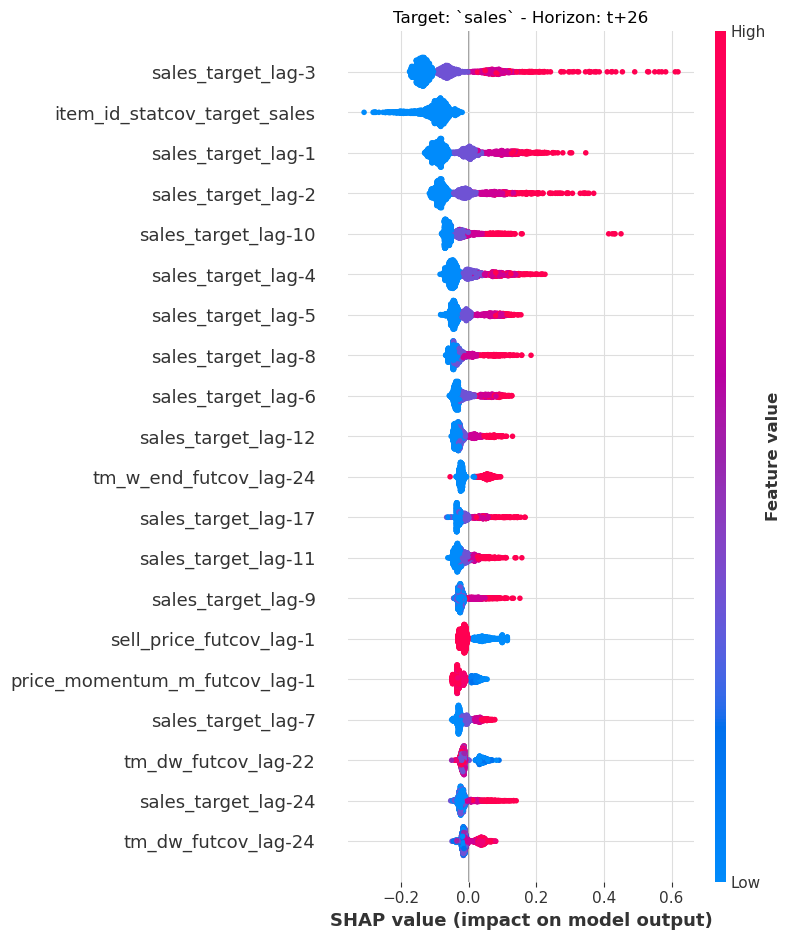

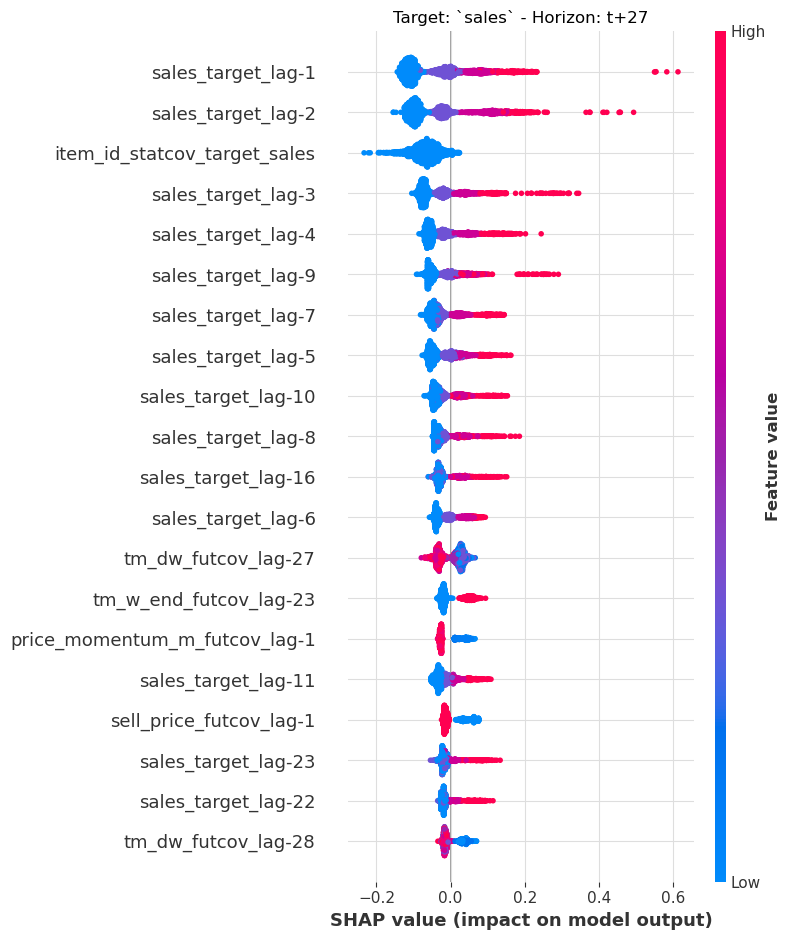

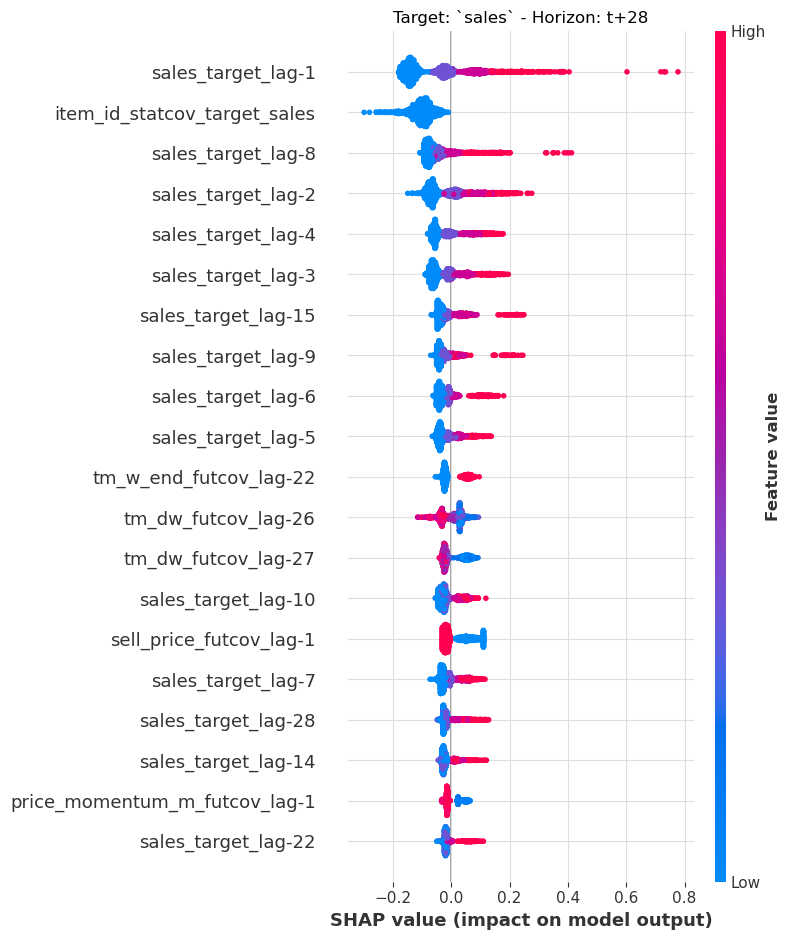

In [16]:
from darts.explainability import ShapExplainer

model =  LightGBMModel.load(f"/path/to/BasicModels/lgbm/Category_Forecasting/Cat_outchunk/Cat_outchunkCA_1_FOODS")
shap_explainer = ShapExplainer(model=model, background_series=all_train_series_cat['CA_1']['FOODS'][0], background_future_covariates=all_future_covs_cat['CA_1']['FOODS'][0])
shap_values = shap_explainer.summary_plot()

In [28]:
import shap
shap.initjs()

<Axes: xlabel='date'>

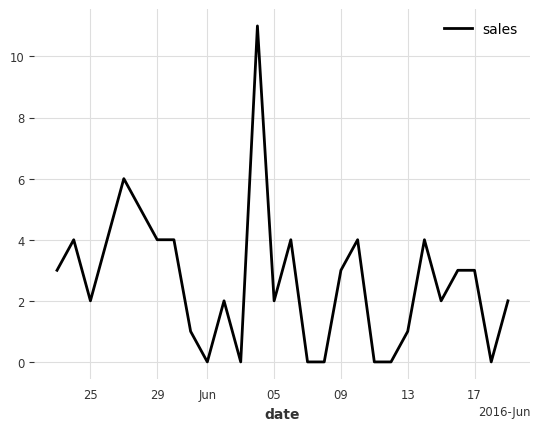

In [33]:
all_test_series_cat['CA_1']['FOODS'][10].plot()

In [36]:
foreground_target = all_test_series_cat['CA_1']['FOODS'][10]
foreground_future_cov = all_future_covs_cat['CA_1']['FOODS'][10][all_test_series_cat['CA_1']['FOODS'][10].start_time() :]

shap_explainer.force_plot_from_ts(
    foreground_series=foreground_target,
    foreground_future_covariates=foreground_future_cov,
)


In [41]:
foreground_target = all_train_series_cat['CA_1']['FOODS'][10][-28*2:]
foreground_future_cov = all_future_covs_cat['CA_1']['FOODS'][10][foreground_target.start_time() :]

shap_explainer.force_plot_from_ts(
    foreground_series=foreground_target,
    foreground_future_covariates=foreground_future_cov,
)
